In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from scipy.signal import lfilter, firls, decimate

In [4]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def TuningKappaNew(self, kappas):
        assert self.finalRes is not None, "Run main function first!"
        
        MaxM = self.paras.MaxM
        U0 = self.finalRes.U0 
        rAct, n = self.midRes.nXmat.shape
        r = self.paras.r
        Us = []
        for kappac in kappas:
            Us.append(U0 + 2*r*np.log(n)**kappac* (np.arange(1, MaxM+2)))
        Us = np.array(Us)
        numchgs = Us.argmin(axis=1)
        self.numchgs = numchgs
        argIdx = np.argmin(np.diff(numchgs)/np.diff(kappas))
        
        self.Us = Us
        mUs = Us.min(axis=1)
        argmU = np.argmin(mUs)
        
        chgsKappas = []
        for numchg in numchgs:
            chgsKappas.append(self.finalRes.chgMat[numchg-1, :numchg])
        
        res = edict()
        res.kp1 = kappas[argIdx+1]
        res.numChgs1 = numchgs[argIdx+1]
        res.cpts1 = self.finalRes.chgMat[res.numChgs1-1, :res.numChgs1] 
        res.kp2 = kappas[argmU]
        res.numChgs2 = numchgs[argmU]
        res.cpts2 = self.finalRes.chgMat[res.numChgs2-1, :res.numChgs2] 
        res.chgsKappas = chgsKappas
        
        return res
   

In [5]:
def dHdist(set1, set2, n=155):
    set1 = np.array(set1)
    set2 = np.array(set2)
    if len(set2) == 0:
        return 0
    if len(set1) == 0:
        return n
    else:
        absDiff = np.abs(set1.reshape(-1, 1) - set2.reshape(1, -1))
        return absDiff.min(axis=0).max()

In [6]:
def Hdist(set1, set2, n=155):
    d1 = dHdist(set1, set2, n=n)
    d2 = dHdist(set2, set1, n=n)
    return np.max((d1, d2))

In [7]:
resDir = Path("../results")
dataDir = Path("../data")

In [8]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

# 1. Obtain data after HPF

In [9]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

In [10]:
num = 100
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

### sample plots 

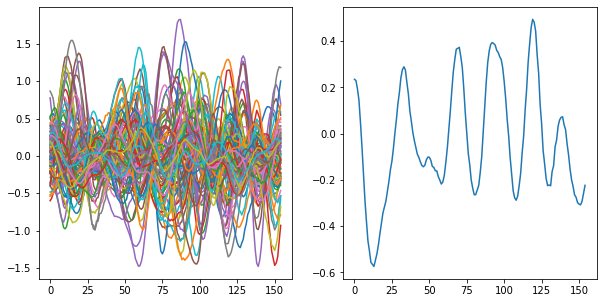

In [11]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(fMRIsHPF[4][i, :])
    
plt.subplot(122)
plt.plot(fMRIsHPF[4][10, :])

In [12]:
#plt.figure(figsize=[10, 10])
#plt.subplot(221)
#plt.ylim([-2, 2])
#plt.plot(fMRIsHPF[20][10, :])
#    
#plt.subplot(222)
#plt.ylim([-2, 2])
#plt.plot(fMRIsHPF[21][10, :])
#
#plt.subplot(223)
#plt.ylim([-2, 2])
#plt.plot(fMRIsHPF[22][10, :])
#    
#plt.subplot(224)
#plt.ylim([-2, 2])
#plt.plot(fMRIsHPF[23][10, :])

In [13]:
#plt.ylim([-2, 2])
#plt.plot(seamedDatas[21][10, :])

# 2. Obtain seamed data

1. divide whole data into 4 segments
2. the grand truth are different for different data

In [14]:
GTs = np.array([
   [30, 85, 130],
   [20, 55, 80],
   [80, 105, 135],
   [35, 65, 100],
   [50, 105, 125]
] * 5)


In [15]:
d, n = fMRIsHPF[0].shape

In [16]:
seamedDatas = [np.zeros((d, n)) for i in range(num)]
for j, GT in enumerate(GTs):
    GT = GT - 1
    GT2 = np.concatenate([GT, [n]]) + 1 
    GT1 = np.concatenate([[0], GT+1])
    for k in range(len(GT)+1):
        seamedDatas[(j*4)+0][:, GT1[k]:GT2[k]] = fMRIsHPF[(j*4)+k%4][:, GT1[k]:GT2[k]]
        seamedDatas[(j*4)+1][:, GT1[k]:GT2[k]] = fMRIsHPF[(j*4)+(k+1)%4][:, GT1[k]:GT2[k]]
        seamedDatas[(j*4)+2][:, GT1[k]:GT2[k]] = fMRIsHPF[(j*4)+(k+2)%4][:, GT1[k]:GT2[k]]
        seamedDatas[(j*4)+3][:, GT1[k]:GT2[k]] = fMRIsHPF[(j*4)+(k+3)%4][:, GT1[k]:GT2[k]]

### sample plots 

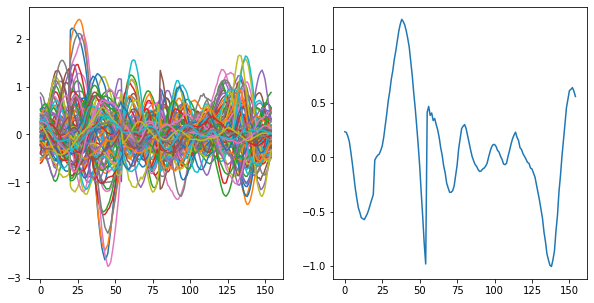

In [17]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(seamedDatas[4][i, :])
    
plt.subplot(122)
plt.plot(seamedDatas[4][10, :])

# 3. Detection for kappa

In [18]:
kappa = 1.53
r =10 
Lmin = 4

results = []
kappas = np.arange(0.68, 4, 0.01)
thdist = 0
for i in tqdm(range(num)):
    Ymat = seamedDatas[i]
    simuDet = TVDNDetect1(Ymat=Ymat,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=1, freq=0.5, lamb=1e-4, showProgress=False, 
                          decimateRate=None, is_detrend=False)
    simuDet()
    chdist = Hdist(simuDet.finalRes.chgMat[2, :3], GTs[i//4])
    thdist += chdist
    
    #print(i+1, np.round(thdist/(i+1), 3), Hdist(simuDet.finalRes.chgMat[2, :3], GTs[i//4]), simuDet.finalRes.chgMat[2, :3], GTs[i//4])
    res = simuDet.TuningKappaNew(kappas)
    results.append(res.chgsKappas)

In [19]:
hdists = []
for k, ress in enumerate(results):
    GT = GTs[k//4]
    hdist = [Hdist(GT, res)for res in ress]
    hdists.append(hdist) 

In [20]:
hdists = np.array(hdists)

In [21]:
mhdist = hdists.mean(axis=0)

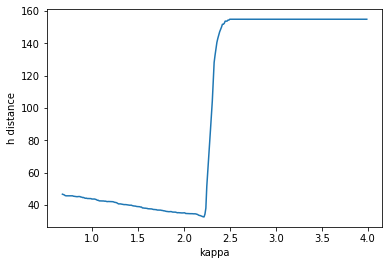

In [22]:
plt.xlabel("kappa")
plt.ylabel("h distance")
plt.plot(kappas, mhdist)

In [23]:
optKappa = kappas[np.argmin(mhdist)];optKappa

2.2200000000000015

# 4. Detection on optimal kappa

## Data 9

In [24]:
fMRI9 = fMRIs[0, 9]["fMRI"][:90, :]
fMRI9 = detrend(fMRI9)
hpffMRI = lfilter(hbp, 1, fMRI9)
hpffMRI = hpffMRI[:, 25:]

In [25]:
r = 10 
Lmin = 4

In [26]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 2.2200000000000015,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


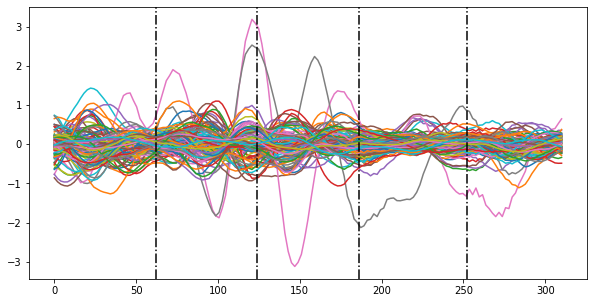

In [27]:
fMRIDet.PlotEcpts()

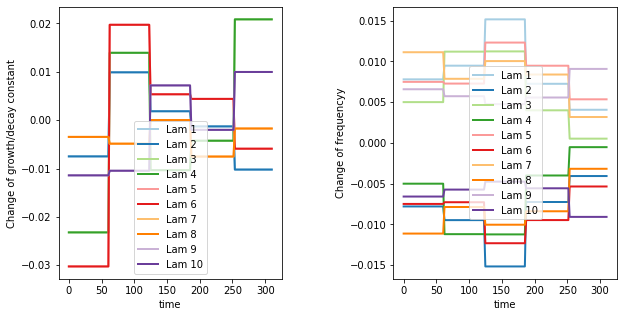

In [28]:
fMRIDet.PlotEigenCurve()

In [29]:
print(fMRIDet)

+-------------+-------------------+--------------------+------+
| Num of CPTs |   Estiamted CPTs  |        MSE         | Rank |
+-------------+-------------------+--------------------+------+
|      4      | [ 31  62  93 126] | 3.4255940669774114 |  10  |
+-------------+-------------------+--------------------+------+


## Data 100

In [30]:
fMRI100 = fMRIs[0, 100]["fMRI"][:90, :]
fMRI100 = detrend(fMRI100)
hpffMRI = lfilter(hbp, 1, fMRI100)
hpffMRI = hpffMRI[:, 25:]

In [31]:
r = 10
Lmin = 4

In [32]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 2.2200000000000015,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


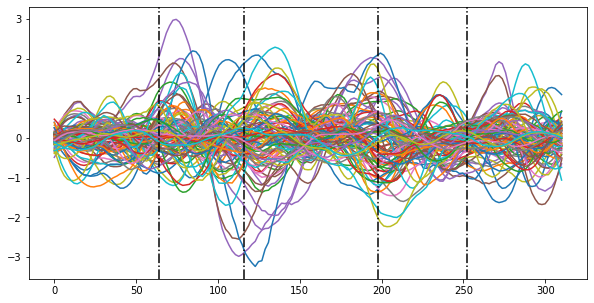

In [33]:
fMRIDet.PlotEcpts()

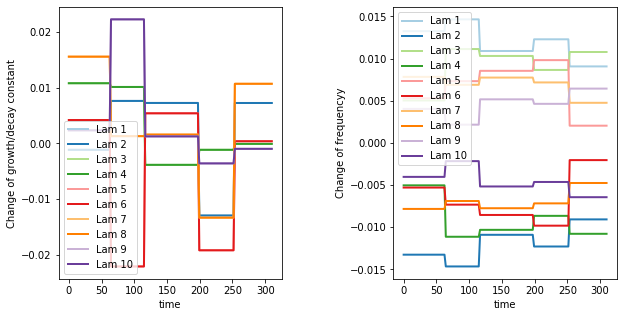

In [34]:
fMRIDet.PlotEigenCurve()

In [35]:
print(fMRIDet)

+-------------+-------------------+--------------------+------+
| Num of CPTs |   Estiamted CPTs  |        MSE         | Rank |
+-------------+-------------------+--------------------+------+
|      4      | [ 32  58  99 126] | 1.2899541650589286 |  10  |
+-------------+-------------------+--------------------+------+
